In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
words=open('names.txt','r').read().splitlines()
char=sorted(set(''.join(words))) 
stoi={s:(i+1) for i,s in enumerate(char)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
block_size=3

In [3]:
def build_dataset(words):
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    xs=torch.tensor(x)    
    ys=torch.tensor(y)
    return xs,ys

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

x_train,y_train=build_dataset(words[:n1])
x_dev,y_dev=build_dataset(words[n1:n2])
x_test,y_test=build_dataset(words[n2:])

In [4]:
n_emb=10
n_hidden=64

g=torch.Generator().manual_seed(2147483647)
#embedding
c=torch.randn(vocab_size, n_emb, generator=g)
#layer1
w1=torch.randn(n_emb*block_size, n_hidden,generator=g)*(5/3)*(1/(n_emb*block_size)**0.5)
b1=torch.randn(n_hidden, generator=g)*0.1
#layer2
w2=torch.randn(n_hidden, vocab_size, generator=g)*0.01
b2=torch.randn(vocab_size, generator=g)*0.1
#batchnorm
bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)

parameters=[c, w1, b1, w2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

4137


In [5]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
batch_size=32
n=batch_size
ix=torch.randint(0,x_train.shape[0],(batch_size,),generator=g)
xs,ys=x_train[ix],y_train[ix]

In [7]:
emb=c[xs]
embcat=emb.view(emb.shape[0],-1)
hpraw=embcat@w1+b1

#bactch norm
bn_mean=1/n*hpraw.sum(0,keepdim=True)
bndiff=hpraw-bn_mean
bndiff2=bndiff**2
bn_var=1/(n-1)*bndiff2.sum(0,keepdim=True)
bn_var_inv=(bn_var+1e-5)**-0.5
bnraw=bndiff*bn_var_inv
hpreact=bngain*bnraw+bnbias

#non linear
hp=torch.tanh(hpreact)

#2nd layer
logits=hp@w2+b2

#prob calcn
logitsmax=logits.max(1,keepdim=True).values
normlogits=logits-logitsmax
counts=normlogits.exp()
counts_sum=counts.sum(1,keepdim=True)
counts_sum_inv=(counts_sum)**-1
prob=counts*counts_sum_inv
logprobs=prob.log()
loss=-logprobs[range(n),ys].mean()

for p in parameters:
    p.grad=None

for t in [logprobs,prob,counts_sum_inv,counts_sum,counts,
         normlogits,logitsmax,logits,hp,hpreact,bnraw,bn_var_inv,bn_var,bndiff2,bndiff,
         bn_mean,hpraw,embcat,emb]:
    t.retain_grad()

loss.backward()
loss



tensor(3.2968, grad_fn=<NegBackward0>)

In [8]:
hpraw.shape

torch.Size([32, 64])

In [1]:
# This is the implementation of mini batch GD due to n
# here n changes each and every cycle and is random and loss is claculated and backpropagated with that bacth size
# if loss is calc with 1 training example at a time i.e. n=1 ,then SGD
# if whole training example is used at a time i.e. n=len(data) ,then BGD (Batched Gradient Descent)

In [9]:
delogprobs = torch.zeros_like(logprobs)
delogprobs[range(n), ys] = -1.0/n
deprob=1.0/prob*delogprobs
decounts_sum_inv=(deprob*counts).sum(1,keepdim=True)
decounts=deprob*counts_sum_inv
decounts_sum=-1*counts_sum**-2*decounts_sum_inv
decounts+=torch.ones_like(counts)*decounts_sum
denormlogits=counts*decounts
delogits=denormlogits.clone()
delogitsmax=-denormlogits.sum(1,keepdim=True)
delogits+=F.one_hot(logits.max(1).indices,num_classes=logits.shape[1])*delogitsmax
dehp=delogits@w2.T
dew2=hp.T@delogits
deb2=delogits.sum(0)
dehpreact=(1-hp**2)*dehp
debngain=(bnraw*dehpreact).sum(0,keepdim=True)
debnraw=bngain*dehpreact
debnbias=dehpreact.sum(0,keepdim=True)
debndiff=bn_var_inv*debnraw
debn_var_inv=(bndiff*debnraw).sum(0,keepdim=True)
debn_var=(-0.5*(bn_var + 1e-5)**-1.5) *debn_var_inv
debndiff2=(1.0/(n-1)*torch.ones_like(bndiff2)*debn_var)
debndiff+=2*bndiff*debndiff2
dehpraw=debndiff.clone()
debn_mean=-debndiff.sum(0,keepdim=True)
dehpraw += 1.0/n * (torch.ones_like(hpraw) * debn_mean)
deembcat=dehpraw@w1.T
dew1=embcat.T@dehpraw
deb1=dehpraw.sum(0)
demb = deembcat.view(emb.shape)
dc = torch.zeros_like(c)

for k in range(xs.shape[0]):
  for j in range(xs.shape[1]):
    ix = xs[k,j]
    dc[ix] += demb[k,j]

cmp('logprobs', delogprobs, logprobs)
cmp('probs', deprob, prob)
cmp('counts_sum_inv', decounts_sum_inv, counts_sum_inv)
cmp('counts_sum', decounts_sum, counts_sum)
cmp('counts', decounts, counts)
cmp('norm_logits', denormlogits, normlogits)
cmp('logit_maxes', delogitsmax, logitsmax)
cmp('logits', delogits, logits)
cmp('h', dehp, hp)
cmp('W2', dew2, w2)
cmp('b2', deb2, b2)
cmp('hpreact', dehpreact, hpreact)
cmp('bngain', debngain, bngain)
cmp('bnbias', debnbias, bnbias)
cmp('bnraw', debnraw, bnraw)
cmp('bnvar_inv', debn_var_inv, bn_var_inv)
cmp('bnvar', debn_var, bn_var)
cmp('bndiff2', debndiff2, bndiff2)
cmp('bndiff', debndiff, bndiff)
cmp('bnmeani', debn_mean, bn_mean)
cmp('hpraw', dehpraw, hpraw)
cmp('embcat', deembcat, embcat)
cmp('W1', dew1, w1)
cmp('b1', deb1, b1)
cmp('emb', demb, emb)
cmp('C', dc, c)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [10]:
# calculating loss easily using torch.nn.functional module

loss_module=F.cross_entropy(logits,ys)
print(f'loss_modules:{loss_module} and diff is {loss-loss_module}')

loss_modules:3.296769618988037 and diff is -4.76837158203125e-07


this above loss is easier to calculate in both fwd and backward pass

In [11]:
# backward pass for loss

dlogits = F.softmax(logits, 1)
dlogits[range(n), ys] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


In [12]:
F.softmax(logits,dim=1)[0]

tensor([0.0434, 0.0369, 0.0356, 0.0364, 0.0329, 0.0465, 0.0415, 0.0422, 0.0360,
        0.0344, 0.0364, 0.0332, 0.0411, 0.0353, 0.0327, 0.0352, 0.0318, 0.0318,
        0.0330, 0.0446, 0.0408, 0.0316, 0.0383, 0.0391, 0.0435, 0.0349, 0.0311],
       grad_fn=<SelectBackward0>)

In [13]:
ys[0]

tensor(8)

In [14]:
(dlogits[0]*n)

tensor([ 0.0434,  0.0369,  0.0356,  0.0364,  0.0329,  0.0465,  0.0415,  0.0422,
        -0.9640,  0.0344,  0.0364,  0.0332,  0.0411,  0.0353,  0.0327,  0.0352,
         0.0318,  0.0318,  0.0330,  0.0446,  0.0408,  0.0316,  0.0383,  0.0391,
         0.0435,  0.0349,  0.0311], grad_fn=<MulBackward0>)

In [15]:
dlogits[0].sum()

tensor(-1.1642e-09, grad_fn=<SumBackward0>)

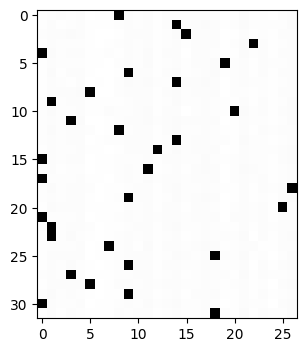

In [16]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach().numpy(),cmap='grey');

In [17]:
#backward pass for batch normalization 


hpreact_fast=bngain*(hpraw-hpraw.mean(0,keepdim=True))/torch.sqrt(hpraw.var(0,keepdim=True,unbiased=True)+1e-5)+bnbias
print(f'max diff is {(hpreact_fast-hpreact).abs().max()}')

# dhp=logits@w1.T *dlogits
# dhpreact=[1-hp**2]*dhp
# dhpbn=bngain*dhpreact



max diff is 4.76837158203125e-07


In [18]:
dehpraw=bngain*bn_var_inv*(n**-1)*((n*dehpreact-dehpreact.sum(0)-n/(n-1)*bnraw*(dehpreact*bnraw).sum(0)))

cmp('hpraw',dehpraw,hpraw)

hpraw           | exact: False | approximate: True  | maxdiff: 5.820766091346741e-11


In [19]:
# rerun from here voli


In [21]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
up=[]
g = torch.Generator().manual_seed(2147483647) # for reproducibility
c  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
w2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [c, w1, b1, w2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
batch_size = 32
n = batch_size # convenience
lossi = []
max_steps=200000
with torch.no_grad():
    for i in range(max_steps):
        ix=torch.randint(0,x_train.shape[0],(batch_size,),generator=g)
        xs,ys=x_train[ix],y_train[ix]
        
        emb=c[xs]
        embcat=emb.view(emb.shape[0],-1)
        hpraw=embcat@w1+b1
            
        #     # batch norm
        # bn_mean=1/n*hpraw.sum(0,keepdim=True)
        # bndiff=hpraw-bn_mean
        # bndiff2=bndiff**2
        # bn_var=1/(n-1)*bndiff2.sum(0,keepdim=True)
        # bn_var_inv=(bn_var+1e-5)**-0.5
        # bnraw=bndiff*bn_var_inv
        # hpreact=bngain*bnraw+bnbias

        bnmean = hpraw.mean(0, keepdim=True)
        bnvar = hpraw.var(0, keepdim=True, unbiased=True)
        bn_var_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hpraw - bnmean) * bn_var_inv
        hpreact = bngain * bnraw + bnbias
        
            
            
            #non linear
        hp=torch.tanh(hpreact)
            
            #2nd layer
        logits=hp@w2+b2
            
            #prob calcn
            # logitsmax=logits.max(1,keepdim=True).values
            # normlogits=logits-logitsmax
            # counts=normlogits.exp()
            # counts_sum=counts.sum(1,keepdim=True)
            # counts_sum_inv=(counts_sum)**-1
            # prob=counts*counts_sum_inv
            # logprobs=prob.log()
            # loss=-logprobs[range(n),ys].mean()
        loss=F.cross_entropy(logits,ys)
            
        for p in parameters:
            p.grad=None
            
        # for t in [loss,logits,hp,hpreact,hpraw,embcat,emb]:
        #         t.retain_grad()
        
        dlogits=F.softmax(logits,1)
        dlogits[range(n),ys]-=1
        dlogits/=n
        
        dhp = dlogits @ w2.T 
        dw2= hp.T @ dlogits 
        db2=dlogits.sum(0)
        
        dhpreact=(1-hp**2)* dhp
        
        dhpraw=bngain*bn_var_inv*(n**-1)*((n*dhpreact-dhpreact.sum(0)-n/(n-1)*bnraw*(dhpreact*bnraw).sum(0)))
        dbngain=(bnraw * dhpreact).sum(0,keepdim=True)
        dbnbias=dhpreact.sum(0,keepdim=True)
        
        dembcat=dhpraw@w1.T 
        dw1=embcat.T @dhpraw 
        db1= dhpraw.sum(0)
        
        demb=dembcat.view(emb.shape)
        dc=torch.zeros_like(c)
        for j in range(xs.shape[0]):
            for k in range(xs.shape[1]):
                ix=xs[j,k]
                dc[ix]+=demb[j,k]
        grads = [dc, dw1, db1, dw2, db2, dbngain, dbnbias]
        
        lr = 0.1 if i < 100000 else 0.01 
        for p,grad in zip(parameters,grads):
            p.data+=-lr*grad
            # up.append((lr*grad).std()/p.data.std().log10().item())
        if i % 10000 == 0: # print every once in a while
          print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')


12297
      0/ 200000: 3.7930
  10000/ 200000: 2.2066
  20000/ 200000: 2.4070
  30000/ 200000: 2.4507
  40000/ 200000: 1.9550
  50000/ 200000: 2.4428
  60000/ 200000: 2.3807
  70000/ 200000: 2.0548
  80000/ 200000: 2.3471
  90000/ 200000: 2.1575
 100000/ 200000: 1.9879
 110000/ 200000: 2.3580
 120000/ 200000: 2.0037
 130000/ 200000: 2.4977
 140000/ 200000: 2.2839
 150000/ 200000: 2.1557
 160000/ 200000: 1.9612
 170000/ 200000: 1.8421
 180000/ 200000: 2.0389
 190000/ 200000: 1.9239


layer 199999 (      tanh): mean -0.00, std 0.66, saturated: 11.28%


Text(0.5, 1.0, 'activation distribution')

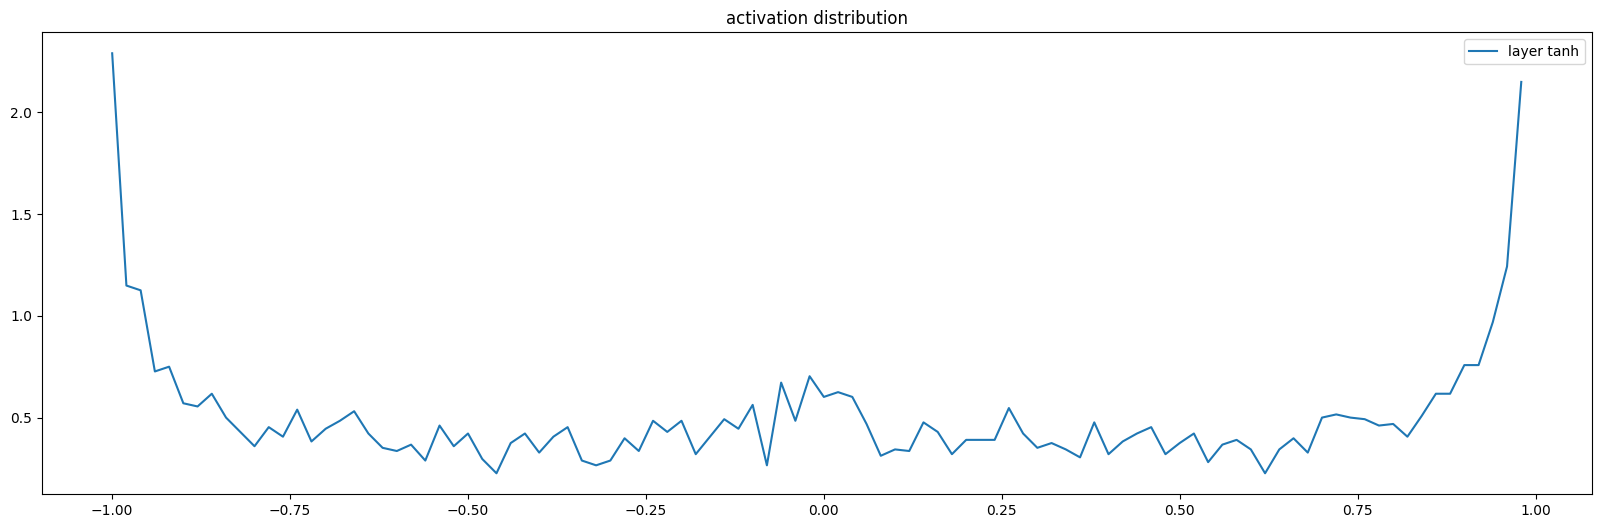

In [22]:
plt.figure(figsize=(20, 6)) # width and height of the plot
legends = []
t = hp
print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i,'tanh', t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
hy, hx = torch.histogram(t, density=True)
plt.plot(hx[:-1].detach(), hy.detach())
legends.append(f'layer tanh')
plt.legend(legends);
plt.title('activation distribution')


layer 199999:tanh, 	 mean:0.000,	 std:0.007


Text(0.5, 1.0, 'activation distribution')

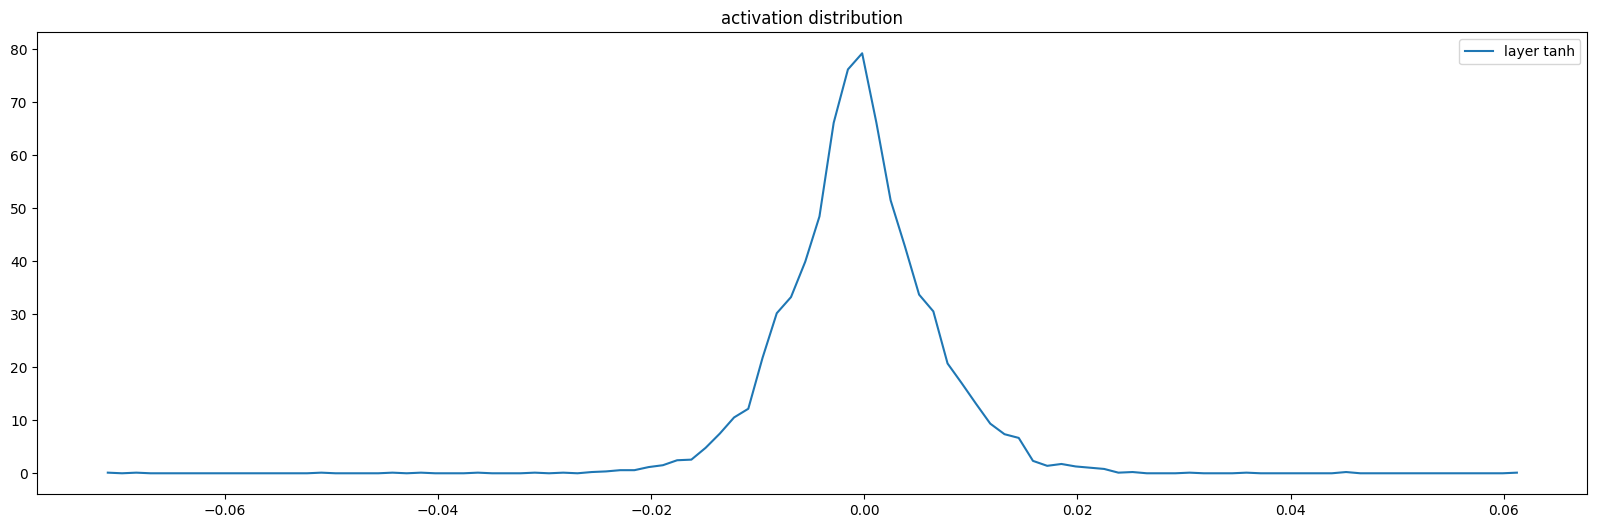

In [23]:
plt.figure(figsize=(20,6))
legend=[]
t=dhp
print(f'layer {i}:tanh, \t mean:{t.mean():.3f},\t std:{t.std():.3f}')
hy,hx=torch.histogram(t,density=True)
plt.plot(hx[:-1].detach(),hy.detach());
legend.append(f'layer tanh')
plt.legend(legends);
plt.title('activation distribution')


weight   (27, 10) | mean -0.000000 | std 1.579903e-02 | grad:data ratio 1.000000e+00
weight  (30, 200) | mean +0.000104 | std 1.064089e-02 | grad:data ratio 1.000000e+00
weight  (200, 27) | mean +0.000000 | std 1.936994e-02 | grad:data ratio 1.000000e+00
weight   (1, 200) | mean +0.000369 | std 9.242929e-03 | grad:data ratio 1.000000e+00
weight   (1, 200) | mean +0.002480 | std 1.715554e-02 | grad:data ratio 1.000000e+00


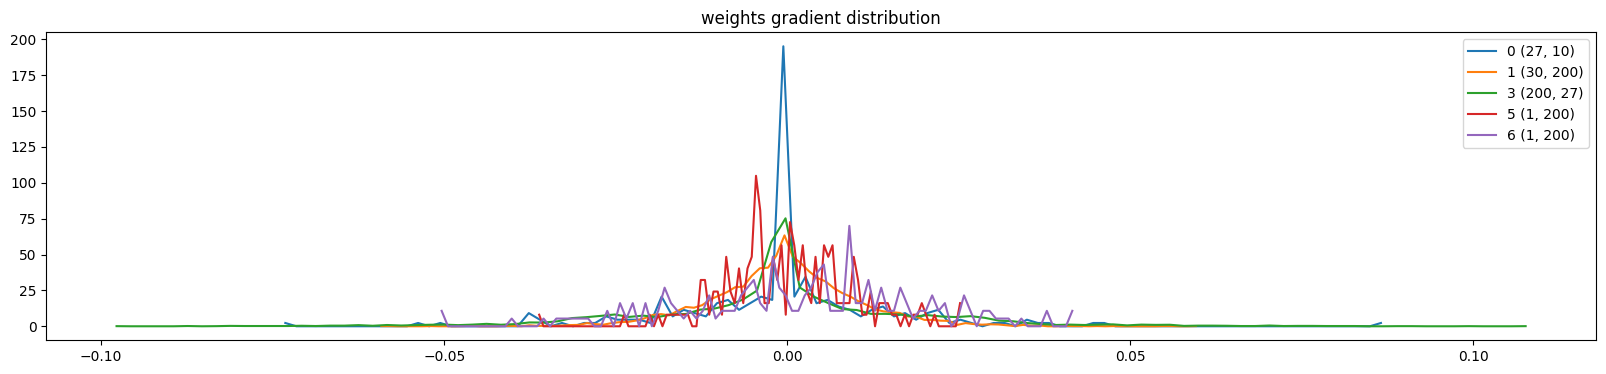

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(grads):
  t = p
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [27]:
with torch.no_grad():
  # pass the training set through
  emb = c[x_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_dev, y_dev),
    'test': (x_test, y_test),
  }[split]
  emb = c[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ w1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ w2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070697784423828
val 2.1103005409240723


In [29]:
# g = torch.Generator().manual_seed(2147483647 )

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = c[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ w1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ w2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

heylani.
amoe.
cynslyn.
jayces.
eer.
lodoai.
zakinsten.
nada.
aft.
elidah.
imahrisaani.
gurw.
adel.
livrae.
kate.
holesh.
voanoelisiana.
naraithamyla.
jahcelee.
rosleyla.
